In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import sys
basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')


## Build Composite library

In [22]:
from utils.library.composite_library import *
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]
    
extra_functions = [
    lambda data: symmetric_tensor_powers(data, 'm_ij'),
    lambda data: active_strain_decomposition_mesh(data, key='m_ij'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_full', 'E_passive', 'E_active']),
    lambda data: add_static_sources_mesh(data, couple='m_ij'),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
    lambda data: material_derivative_terms(data, key='m_ij'),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())

with h5py.File('Public/mesh_dynamics_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries, filename='mesh_derivative_library.h5')
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            take_time_derivatives(group, libraries, window_length=9)
            library_to_tangent_space(group, libraries)
            pbar.update()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Learn Myosin model

In [76]:
import pysindy as ps
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import FlySINDy

tmin, tmax = 10, 20

with h5py.File('Public/mesh_dynamics_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', tmin, tmax, collect_mesh_data)
#X, X_dot, feature_names = shift_material_derivative(X, X_dot, feature_names)
    
optimizer = ps.STLSQ(threshold=2e-2, alpha=1e0, normalize_columns=True)

constraint_lhs = np.zeros([2, len(feature_names)])
constraint_rhs = np.ones(2)
constraint_lhs[0, feature_names.index('m_ij')] = -5 #tau = 5 min
#constraint_lhs[1, feature_names.index('[O, m_ij]')] = -1
constraint_lhs[1, feature_names.index('v dot grad m_ij')] = -1


optimizer = ps.ConstrainedSR3(constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs,
                              thresholder='l1',
                              threshold=1e-2, nu=1e-2, tol=1e-2, max_iter=1000, verbose=True)
sindy = FlySINDy(
    optimizer=optimizer,
    feature_names=feature_names,
    n_models=1)
sindy.fit(x=X, x_dot=X_dot)
sindy.print(lhs=['D_t m_ij'])

  0%|          | 0/7 [00:00<?, ?it/s]

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 4.3118e+00 ... 3.4000e-01 ... 4.1592e-01 ... 4.7311e+00
       100 ... 3.9618e+00 ... 1.9537e-01 ... 2.1915e-01 ... 4.1829e+00
       200 ... 4.2942e+00 ... 1.2206e-01 ... 1.2532e-01 ... 4.4208e+00
       300 ... 4.3633e+00 ... 9.0101e-02 ... 9.6048e-02 ... 4.4602e+00
       400 ... 4.3518e+00 ... 9.0275e-02 ... 7.4438e-02 ... 4.4271e+00
       500 ... 4.3615e+00 ... 9.0865e-02 ... 5.2961e-02 ... 4.4153e+00
       600 ... 4.3447e+00 ... 8.6404e-02 ... 3.2120e-02 ... 4.3777e+00
       700 ... 4.3536e+00 ... 7.6735e-02 ... 1.6883e-02 ... 4.3713e+00
D_t m_ij = 0.072 Static_DV Tr(m_ij) + -0.089 c Static_DV Tr(m_ij) + 0.209 c m_ij + -0.190 m_ij + 0.046 m_ij^2 + -0.990 v dot grad m_ij


## Predict using learned model

  0%|          | 0/21 [00:00<?, ?it/s]

Initializing
Loaded mesh gradient operators
Using scipy solve_ivp
Done


  0%|          | 0/21 [00:00<?, ?it/s]

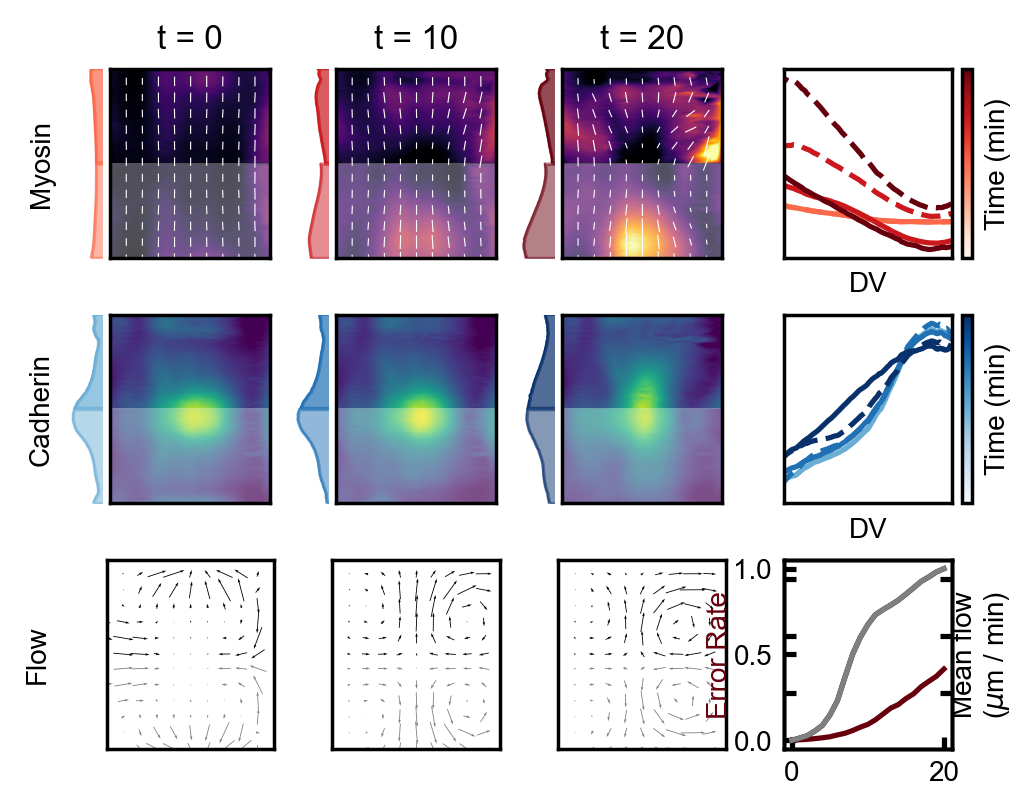

In [88]:
from scipy.interpolate import interp1d

from utils.geometry.closed_loop import ClosedLoopMesh
from utils.geometry.geometry_utils import MeshInterpolator, TangentSpaceTransformer
from utils.geometry.transforms import LeftRightSymmetrize
from utils.forecasting.plot_utils import *

mesh_int = MeshInterpolator().fit(None)
tangent  = TangentSpaceTransformer().fit(None)
lrsym    = LeftRightSymmetrize().fit(None)

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/mesh_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    M0 = data['fields/m_ij'][t_mask, ...][()]
    S0 = data['fields/c'][t_mask, ...][()]
    V0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
m0, s0, v0 = [], [], []
for i in tqdm(range(len(t0))):
    m0.append(tangent.inverse_transform(lrsym.transform(M0[i])))
    v0.append(tangent.inverse_transform(lrsym.transform(V0[i])))
    s0.append(lrsym.transform(S0[i]))

class FittedModel(ClosedLoopMesh):
    def rhs(self, m, s, v, E):
        E_a = self.active.transform(E, m)
        E_p = E - E_a
        trm = self.einsum_('kkv->v', m)
        smean = s.mean(axis=-1, keepdims=True)
        
        #rhs = -(0.066 - 0.061 * s) * m
        rhs = -(0.066 - 0.061 * smean) * m
        rhs += (0.489 + 0.318 * s) * m * self.einsum_('kkv->v', E)
        #rhs += (0.564 - 0.393 * s) * m * trm
        rhs += (0.564 - 0.493 * s) * m * trm
        #rhs += 0.01 * s * self.gamma_dv_ * trm
        rhs += (0.047 - 0.037 * s) * self.gamma_dv_ * trm
                
        return rhs

#Using a flow field interpolator in the loop instead of a neural network
v_int = interp1d(t0, v0, axis=0, fill_value='extrapolate')
v_model = lambda t, y: v_int(t)

y0 = np.concatenate([
    m0[0].reshape([4, 1797]),
    s0[0].reshape([1, 1797])
])

model = FittedModel(v_model=v_model, sigma=.5)
m, s, v = model.integrate(y0, t0)
print('Done')    

M, S, V = [], [], []
M0, S0, V0 = [], [], []
for i in tqdm(range(len(t0))):
    M.append(mesh_int.inverse_transform(m[i]))
    S.append(mesh_int.inverse_transform(s[i]))
    V.append(mesh_int.inverse_transform(v[i]))
    M0.append(mesh_int.inverse_transform(m0[i]))
    S0.append(mesh_int.inverse_transform(s0[i]))
    V0.append(mesh_int.inverse_transform(v0[i]))

comparison_plot(t0,
                ('Myosin', np.stack(M), np.stack(M0)),
                ('Cadherin', np.stack(S), np.stack(S0)),
                ('Flow', np.stack(V), np.stack(V0)),
                dt=10)

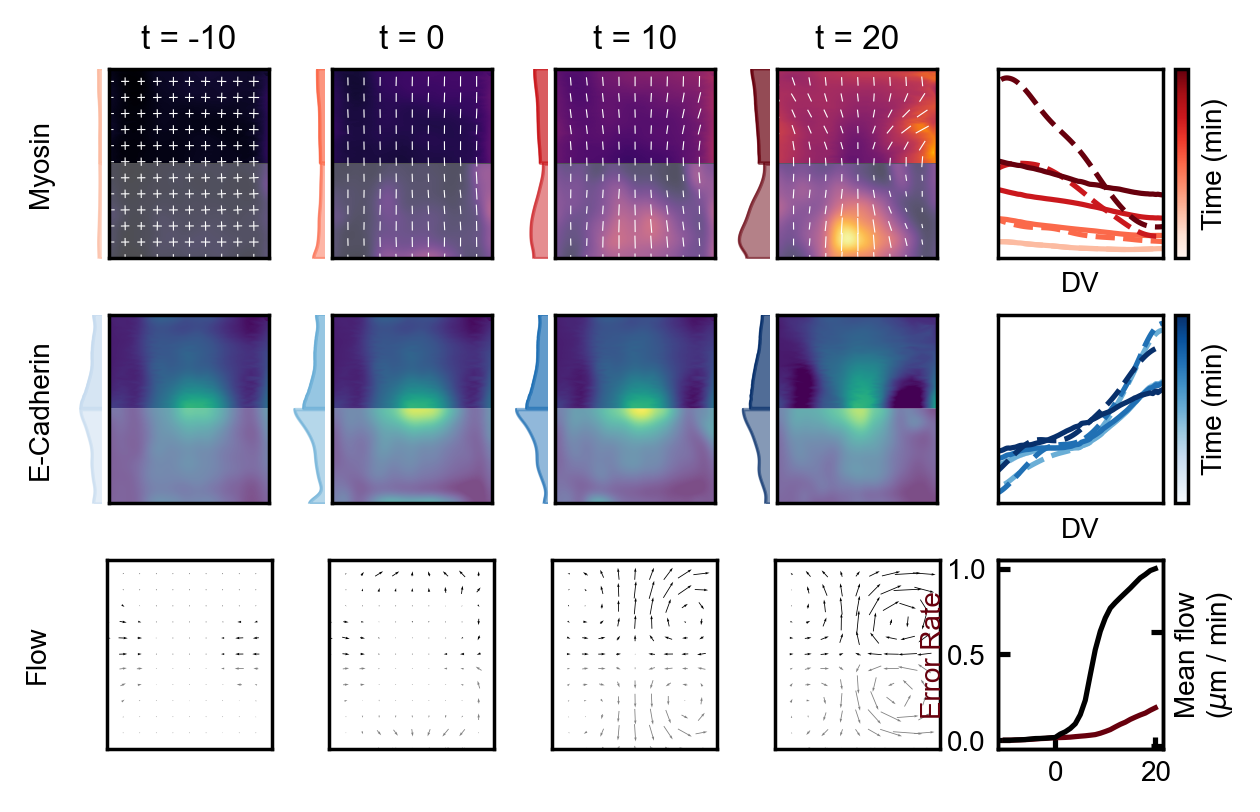

In [83]:
from utils.forecasting.plot_utils import *
comparison_plot(t0,
                ('Myosin', m, m0),
                ('E-Cadherin', s, s0),
                ('Flow', v, v0),
                dt=10)
#plt.savefig('Figures/Figure3/mesh_forecasting.svg', bbox_inches='tight')

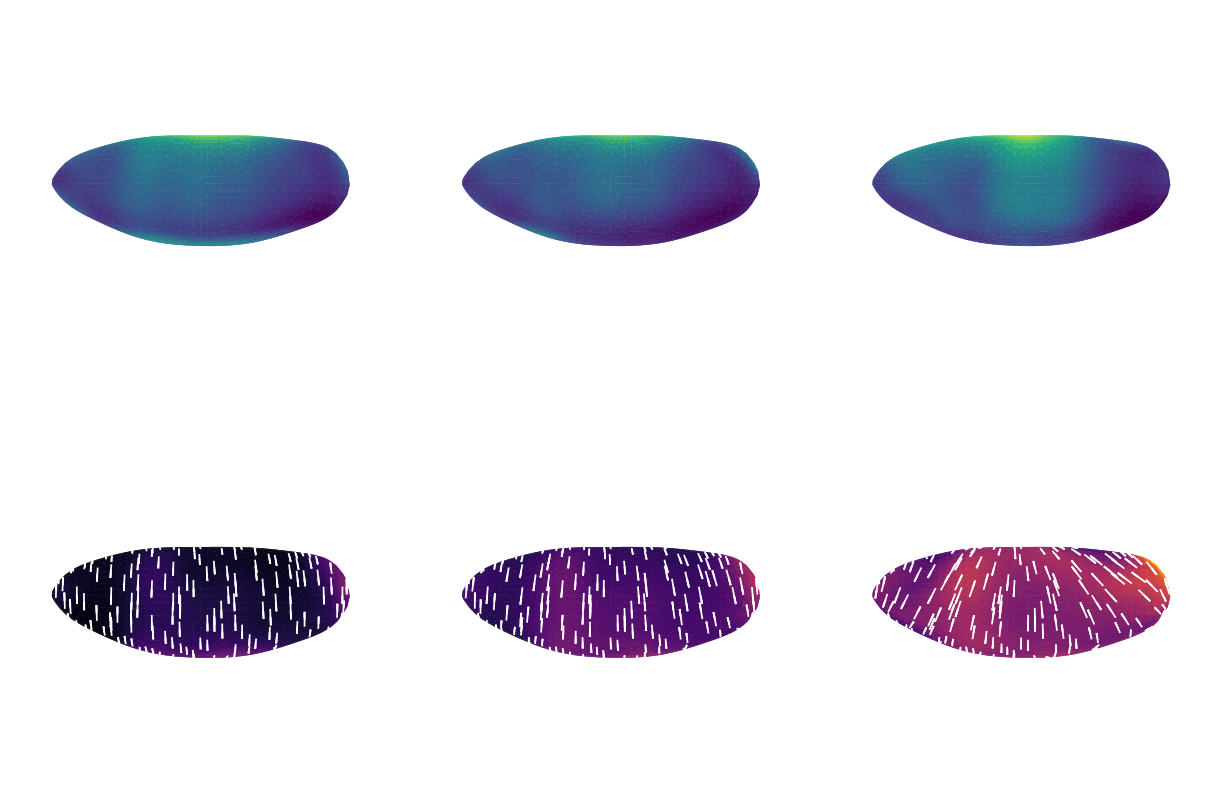

In [8]:
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import TangentSpaceTransformer
from sklearn.pipeline import Pipeline
fig, ax = plt.subplots(2, 3, dpi=250, subplot_kw=dict(projection='3d'))

mnorm = np.linalg.norm(m0, axis=(1, 2))
vmin, vmax = np.min(mnorm), np.max(mnorm)
pipe = Pipeline([
    ('mesh', MeshInterpolator()),
    ('tangent', TangentSpaceTransformer()),
]).fit(mnorm)
    

for i in range(3):
    #plot_tensor3D(ax[0, i], pipe.transform(m0[i*10]), vmin=vmin, vmax=vmax)
    color_3D(ax[0, i], pipe.transform(s0[i*10]))
    plot_tensor3D(ax[1, i], pipe.transform(m[i*10].reshape([2, 2, 236, 200])), vmin=vmin, vmax=vmax)

In [21]:
from utils.geometry.geometry_utils import embryo_mesh

verts = embryo_mesh.coordinates()
pix_scale = 0.2619
verts = verts * pix_scale

ptp = np.ptp(verts, axis=0)
radius = np.mean(ptp[:2]/2)

print(f'3D Embryo: radius={radius:.3g}, circumference={2*np.pi*radius:.3g}, length={ptp[2]:.3g} (all in microns)')
print(f'2D Embryo: circumference={dv_max-dv_min:.3g}, length={ap_max-ap_min:.3g} (all in microns)')

3D Embryo: radius=86.7, circumference=545, length=455 (all in microns)
2D Embryo: circumference=534, length=452 (all in microns)
